# Predicting footballer player wage based on respective FIFA / EAFC plater stats

The problem we are addressing is correctly evaluating a playe's wage based on their stats. With ever more growing talent in the field, it is vital as a football club to accurately price your players to stay competitive. Our goal is to study & build machine learning models to accurately predict a footballer's wage based on a dataset of players wage and stats.

# Importing data

We are going to be utilising the [EA Sports FC 24 complete player dataset](https://www.kaggle.com/datasets/omkargowda/football-players-stats-premier-league-20212022/) from kaggle for player stats and valautions.

Required Python modules:
* Pandas - reading and manipulating data

In [ ]:
import pandas as pd
from copy import deepcopy
# instructing pandas to not truncate column widths when displaying data in interactive mode
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

random_state = 42
datasets_fp = 'datasets/'
encoding = 'unicode_escape'
df = pd.read_csv(datasets_fp+'male_players.csv', encoding=encoding)
df

Let's have a quick look at the dataframe

In [ ]:
df.head(5) # first 5 rows

Let's do a quick analysis of the data and it's columns using the pandas describe() method

In [ ]:
df.describe(include='all') # using include='all' to show us all columns

Let's find out exactly how many columns we have

In [ ]:
len(df.columns) # length of columns list

The current dataset has too many features with a large portion being irrelevant to the task at hand. We will drop the columns that aren't relevant using the .drop() function.

In [ ]:
df.drop([
    'player_url',
    'update_as_of',
    'short_name',
    'long_name',
    'dob',
    'club_name',
    'league_name',
    'club_position',
    'club_loaned_from',
    'club_joined_date',
    'nationality_id',
    'nation_position',
    'body_type',
    'real_face',
    'player_tags',
    'player_traits',
    'fifa_update',
    'league_level',
    'club_team_id',
    'league_id',
    'club_jersey_number',
    'club_contract_valid_until_year',
    'nation_team_id',
    'nation_jersey_number',
    'release_clause_eur',
    'height_cm',
    'weight_kg',
    'ls',
    'st',
    'rs',
    'lw',
    'lf',
    'cf',
    'rf',
    'rw',
    'lam',
    'cam',
    'ram',
    'lm',
    'lcm',
    'cm',
    'rcm',
    'rm',
    'lwb',
    'ldm',
    'cdm',
    'rdm',
    'rwb',
    'lb',
    'lcb',
    'cb',
    'rcb',
    'rb',
    'gk',
], axis=1, inplace=True)
df

We will focusing on the Premier League data only so let's filter the dataset to satisfy this requirement

In [ ]:
df = df[df['league_name'] == 'Premier League'] # filter league_name to 'Premier League'
df

Filter data for non-goalkeeper players only

In [ ]:
df = df[df['main_position'] != 'GK'] # filter out goalkeepers

# Initial data cleansing

Now we have sucessfully imported the dataset, we need to process the data to make it suitable to a machine learning model.

Looking at the data now there are 2 columns that would be useful but need to be altered for a machine learning model:
* player_positions - change to main position with options: forward (FW), midfielder (MD), defender (DF), goalkeeper (GK)

* work_rate - split into 2 columns repensenting attacking work-rate & defensive work-rate respectively.

In [ ]:
#----------------------------------------------------------------------
# Seperate cols: work_rate -> attacking_work_rate & defending_work_rate
#----------------------------------------------------------------------

# work_rate format: '[attacking work rate] / [defending_work_rate]'
def calc_att_work_rate(work_rate: str):
    return work_rate.split('/')[0]

def calc_def_work_rate(work_rate: str):
    return work_rate.split('/')[1]

# Create new attacking and defending work rate columns
df['attacking_work_rate'] = df['work_rate'].apply(lambda work_rate: calc_att_work_rate(work_rate))
df['defending_work_rate'] = df['work_rate'].apply(lambda work_rate: calc_def_work_rate(work_rate))
# Drop old work_rate column
df.drop(['work_rate'], axis=1, inplace=True)

As the goal is to predict the value of a footballer, I need to find a column which quantifies the footballer's value to be the target.

In this case value_eur or wage_eur accurately fit this requirement.

I will check and compare these columns to see which is a best fit

In [ ]:
wage_eur_n_nulls = df['wage_eur'].isnull().sum()
wage_eur_n_nulls

In [ ]:
value_eur_n_nulls = df['value_eur'].isnull().sum()
value_eur_n_nulls

In [ ]:
n_rows = df.shape[0] # Amount of rows
n_rows

In [ ]:
value_eur_n_nulls / n_rows * 100 # Percentage nulls

wage_eur has 0 null values but value_eur has 12. 

Proportionally this is not a lot of null values at only 0.12%, but I will still need to deal with these null values. I do this by dropping the rows with a null value_eur value. 

In [ ]:
df.dropna(subset=['value_eur'], inplace=True)
df.shape[0]

I will now categorise each column in the data into their respective statistical type

#### Categorical
* player_id
* nationality_name
* preferred_foot
* main_position
#### Ordinal
* age
* attacking_work_rate
* defending_work_rate
#### Interval
* overall
* potential
* weak_foot
* skill_moves 
* international_reputation
* pace
* shooting
* passing
* dribbling
* defending
* physic
* attacking_crossing
* attacking_finishing
* attacking_heading_accuracy
* attacking_short_passing
* attacking_volleys
* skill_dribbling
* skill_curve
* skill_fk_accuracy
* skill_long_passing
* skill_ball_control
* movement_acceleration
* movement_sprint_speed
* movement_agility
* movement_reactions
* movement_balance
* power_shot_power
* power_jumping
* power_stamina
* power_strength
* power_long_shots
* mentality_aggression
* mentality_interception
* mentality_positioning
* mentality_vision
* mentality_penalties
* mentality_composure
* defending_marking_awareness
* defending_standing_tackle
* defending_sliding_tackle
* goalkeeping_diving
* goalkeeping_handling
* goalkeeping_kicking
* goalkeeping_positioning
* goalkeeping_reflexes
* goalkeeping_skills


Checking for any more columns with null values

In [ ]:
df.isna().any()

The main generic player attributes (pace, shooting, passing, dribbling, defending, physic) all have null values. I suspect it could be due to goalkeepers not having these specific attributes in FIFA. I will use filtering and the .unique() function to confirm if my suspicions are true.

In [ ]:
df_rows_w_nulls = df[ # filtering the data to rows that have nulls 
    df['pace'].isna()
    | df['shooting'].isna()
    | df['passing'].isna()
    | df['dribbling'].isna()
    | df['defending'].isna()
    | df['physic'].isna()
]
# Get main position unique values to confirm if it's 
# only goalkeepers this applies to
df_rows_w_nulls['main_position'].unique()

In [ ]:
df = df[df['main_position'] != 'GK'] # filter out goalkeepers
# Remove goalkeeping ability data
df.drop([
    'goalkeeping_diving',
    'goalkeeping_handling',
    'goalkeeping_kicking',
    'goalkeeping_positioning',
    'goalkeeping_reflexes',
    'goalkeeping_speed'
], axis=1, inplace=True)
df

There is one more remaining column with null values: mentality_composure. This is an attribute that has only been present in recent FIFA iterations, hence I suspect this to be the reason behind the null values. I will pandas filtering and the .max() function to confirm if my suspicion is true.

In [ ]:
# Most recent fifa iterations with nulls in mentality_composure
df[df['mentality_composure'].isna()]['fifa_version'].max()

My suspicions are confirmed to be true. I will still need to deal with these nulls. As I would still like to keep data from versions 16 and below, I decide to remove this column entirely.

In [ ]:
df.drop(['mentality_composure'], axis=1, inplace=True)

In [ ]:
averages = {}

# Loop through each game version
for version in df['fifa_version'].unique().tolist():
    # Filter dataframe by version
    _df = df[df['fifa_version']==version]
    # Extract average values using .mean() on column
    avg_value = round(_df['value_eur'].mean())
    avg_wage = round(_df['wage_eur'].mean())
    # Create averages dictionary
    averages[version] = {}
    # Save averages for version
    averages[version]['value_eur'] = avg_value
    averages[version]['wage_eur'] = avg_wage
    print(f'FIFA {version}')
    print('Avg value:', avg_value)
    print('Avg wage:', avg_wage, '\n')


adjusted_value_list = []
adjusted_wage_list = []
# Loop through each row
for i, row in df.iterrows():
    # Get version number
    _version = row['fifa_version']
    # Adjust value & wage by calculated inflation ratios
    adjusted_value = row['value_eur'] * (averages[24]['value_eur'] / averages[_version]['value_eur'])
    adjusted_wage = row['wage_eur'] * (averages[24]['wage_eur'] / averages[_version]['wage_eur'])
    # Append to list
    adjusted_value_list.append(adjusted_value)
    adjusted_wage_list.append(adjusted_wage)

# Create new column from list of adjusted values
df['value_eur_adj'] = adjusted_value_list
df['wage_eur_adj'] = adjusted_wage_list


# EDA

In [ ]:
#sns.barplot(df, x='fifa_version', y='value_eur_adj')

In [ ]:
sns.pairplot(
    df.sample(frac=.1,),
    x_vars=['age','overall','value_eur','wage_eur','pace','shooting','skill_ball_control'],
    y_vars=['age','overall','value_eur','wage_eur','pace','shooting','skill_ball_control'],
    kind="hist"
)

# Drop extra columns

In [ ]:
# Drop columns
df.drop([
    'attacking_crossing',
    'attacking_finishing',
    'attacking_heading_accuracy',
    'attacking_short_passing',
    'attacking_volleys',
    'skill_dribbling',
    'skill_curve',
    'skill_fk_accuracy',
    'skill_long_passing',
    'skill_ball_control',
    'movement_acceleration',
    'movement_sprint_speed',
    'movement_agility',
    'movement_reactions',
    'movement_balance',
    'power_shot_power',
    'power_jumping',
    'power_stamina',
    'power_strength',
    'power_long_shots',
    'mentality_aggression',
    'mentality_interceptions',
    'mentality_positioning',
    'mentality_vision',
    'mentality_penalties',
    'defending_marking_awareness',
    'defending_standing_tackle',
    'defending_sliding_tackle',
    'goalkeeping_diving',
    'goalkeeping_handling',
    'goalkeeping_kicking',
    'goalkeeping_positioning',
    'goalkeeping_reflexes',
    'goalkeeping_speed'
], axis=1, inplace=True)
print("\n".join(df.columns))

# Splitting the dataset

In [ ]:
# import train_test_split function from sklearn
# Doc: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# Set target dataset to value_eur column
y = df['value_eur']
# Set features dataset to dataset minus value_eur column using .drop() function
X = df.drop(['value_eur'], axis=1)

# Create train, validation & test splits (80% / 20%)
X_train, X_valid_and_test, y_train, y_valid_and_test = train_test_split(
    X, y, test_size=.2, random_state=random_state
)
# Split remaining validation & test dataset to individual
# validation & test splits (50% / 50%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_and_test, y_valid_and_test, test_size=.5, random_state=random_state
)


# Test if split was as expected by calculating percentage of each set
# This should give us a total split of 80%-10%-10% (train, valid, test)
train_percent = X_train.shape[0] / X.shape[0] * 100
valid_percent = X_valid.shape[0] / X.shape[0]  * 100
test_percent = X_test.shape[0] / X.shape[0]  * 100
total_percent = train_percent+test_percent+valid_percent

print(f'Train: {train_percent}%\
      \nValid: {valid_percent}%\
      \nTest: {test_percent}%\
      \n------------------------\
      \nTotal: {total_percent}%')


# EDA


In [ ]:
# Install dependacies
import seaborn as sns
import matplotlib as mpl

#### Univariate

c:\Users\Ishina\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


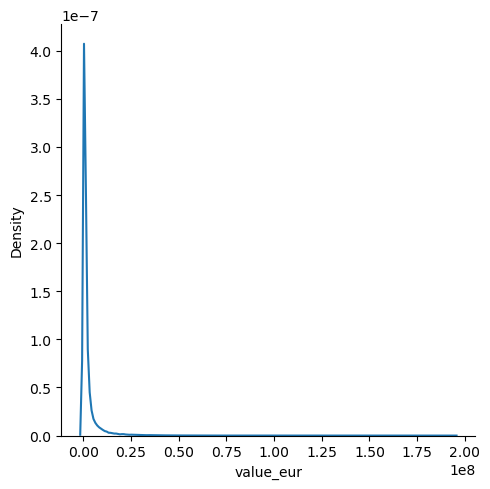

In [101]:
sns.displot(df['value_eur'],  kind='kde')

c:\Users\Ishina\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


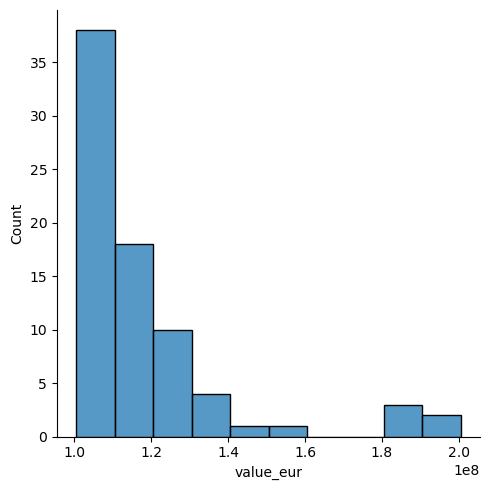

In [89]:
sns.displot(df[df['value_eur'] > 100000000]['value_eur'], binwidth=10000000)

In [ ]:
sns.displot(df['age'], binwidth=1) # binwidth = width of each bar

In [ ]:
sns.boxplot(df['age'], orient='h') # horizontal orientation

In [ ]:
#sns.displot(df['overall'], binwidth=5)
sns.boxplot(df['overall'], orient='h')

In [ ]:
#sns.displot(df['potential'], binwidth=5)
sns.boxplot(df['potential'], orient='h')

In [ ]:
sns.catplot(df, x='fifa_version', kind='count')

In [ ]:
sns.displot(df['preferred_foot'])

In [ ]:
sns.displot(df['preferred_foot'])

In [ ]:
sns.catplot(df, x='skill_moves', kind='count')

In [ ]:
sns.catplot(df, x='weak_foot', kind='count')

In [ ]:
sns.catplot(df, x='international_reputation', kind='count')

In [ ]:
n_records = df.shape[0] # number of records in our dataframe

#loop 5 times (1 for each rating from 1-5)
for i in range(5):
    rating = i+1 # index starts from 0 so add 1 to get rating
    
    # get number of records with this rating
    count = df[df['international_reputation']==rating].shape[0]
    percent = count / n_records * 100
    
    print(f"Intl rep rating {rating}: {percent}%") 

c:\Users\Ishina\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


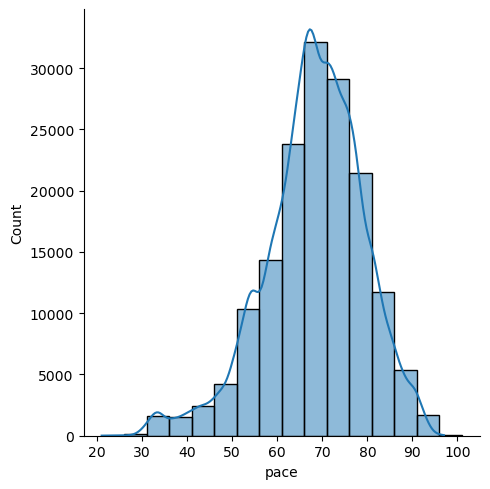

In [111]:
sns.displot(df['pace'], binwidth=5, kde=True)
#sns.boxplot(df, x='pace')

c:\Users\Ishina\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


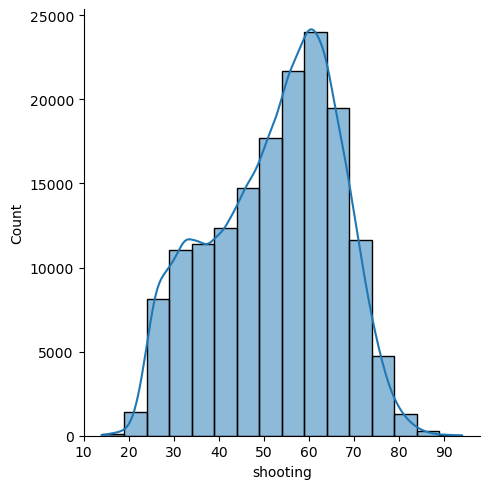

In [105]:
sns.displot(df, x='shooting', binwidth=5, kde=True)

c:\Users\Ishina\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


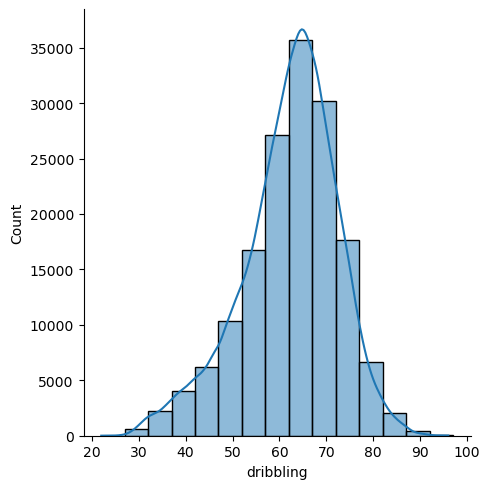

In [106]:
sns.displot(df['dribbling'], binwidth=5, kde=True)

c:\Users\Ishina\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


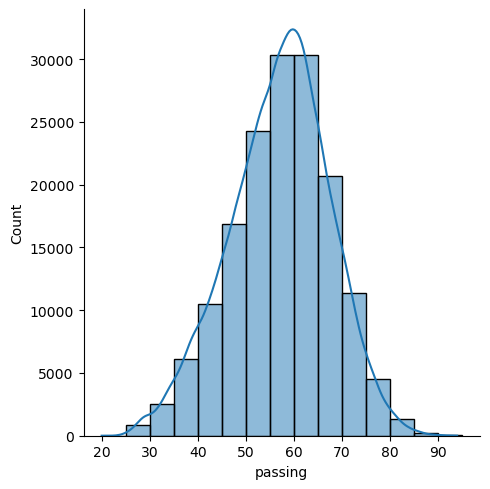

In [107]:
sns.displot(df['passing'], binwidth=5, kde=True)

c:\Users\Ishina\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


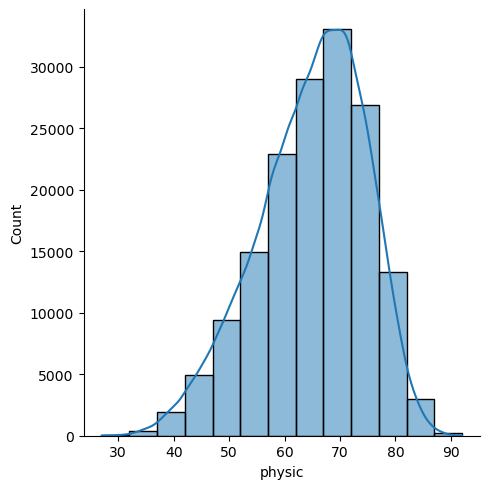

In [108]:
sns.displot(df['physic'], binwidth=5, kde=True)

Need to covert player_positions to usable field

In [ ]:
#----------------------------------
# player_positions -> main_position
#----------------------------------

# list of all outfield positons can be found at https://www.fifplay.com/encyclopedia/position/
forward_positions = [
    'ST', 
    'CF',
    'RF',
    'LF',
    'RW',
    'LW',
]

midfielder_positions = [
    'CM',
    'CDM',
    'CAM',
    'RM',
    'LM',
]

defender_positions = [
    'CB',
    'RB',
    'LB',
    'RWB',
    'LWB',
]

def calc_main_position(positions: str):

    primary_position = positions.split(',')[0] # using first position mentioned as primary position

    if primary_position in forward_positions:
        return 'FW'
    elif primary_position in midfielder_positions:
        return 'MD'
    elif primary_position in defender_positions:
        return 'DF'
    elif primary_position == 'GK':
        return 'GK'
    else:
        return None # no valid position found

# Create new column with function applied to each value
df['main_position'] = df['player_positions'].apply(lambda pos: calc_main_position(pos))
# Show new column
print(df[['player_positions','main_position']])
# Check for nulls
print('\nNulls: ', df['main_position'].isnull().sum())
# Drop old column
df.drop(['player_positions'] ,axis=1,inplace=True)



In [ ]:
sns.catplot(df, x='main_position', kind='count')

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

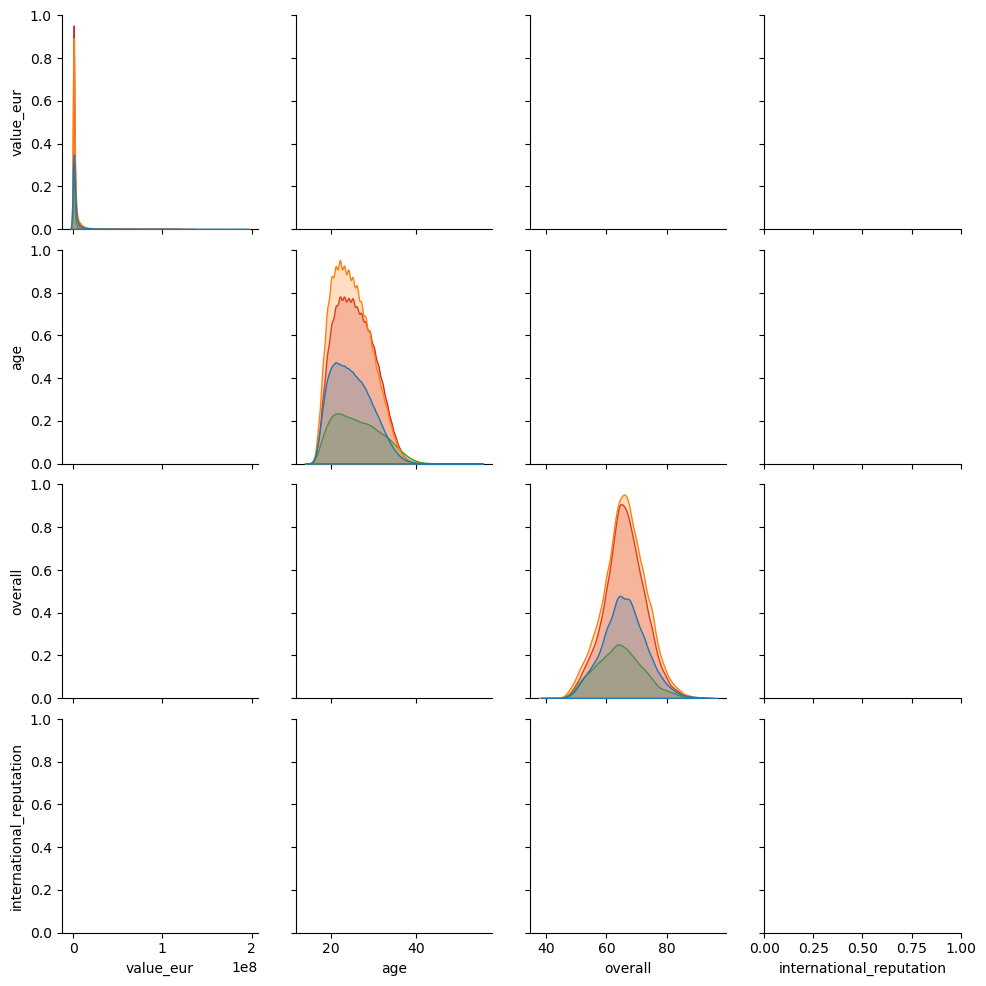

In [125]:
pair_plot_cols = [
    'value_eur',
    'age',
    'overall',
    'international_reputation',
]

sns.pairplot(df, 
             vars=[    
                'value_eur',
                'age',
                'overall',
                'international_reputation'], 
             hue='main_position'
             )

<Axes: xlabel='age', ylabel='value_eur'>

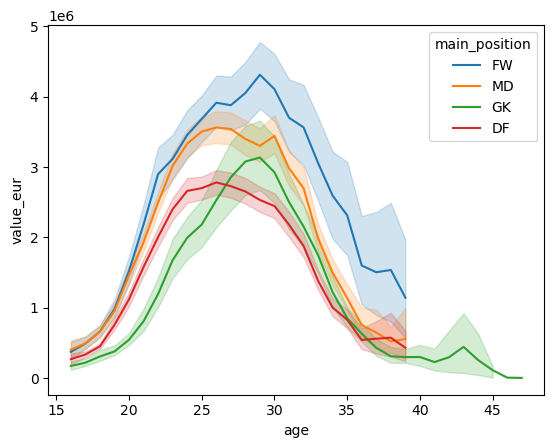

In [82]:
#sns.lineplot(df, x='age', y='value_eur', hue='main_position')